# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

Em Belanger, Alex Chen, Richelle, Robin Siwang Lam

## General Setup

In [1]:
%matplotlib inline

# Data libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules that are necessary
import sklearn

# For sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# ML processing libraries
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Q-Q plot
from statsmodels.api import qqplot

In [2]:
# Load data
data = pd.read_csv("the_office.csv")
# Dialogue data for sentiment analysis
lines = pd.read_csv("The-Office-Lines.csv")

## 1. Introduction

In the project, we will investigate what factors are important for a high IMDB rating episode of the TV show "The Office". Using the insights we found we will shed light on how to produce the highest rated reunion episode. In addition to the historical performance of each episode, we utilised the dialogue in every episode to measure the activeness of characters and to conduct sentiment analysis, because we assumed that both measurements in an episode have an influence on the rating. To deliver a reasonable explanation of the model results, we chose Lasso linear regression as it gave us a model with strong interpretability. Applying Lasso linear regression can help select influential and important factors for the rating. To make the results robust, we conducted cross validation to select the best parameters and understand the model performance. In the end, we interpreted the coefficients of the model to find out which covariates can improve the ratings.


## 2. Exploratory Data Analysis and Feature Engineering

### 2.1 Data Quality Check

Before performing data visualisation, it is good to check whether there is missing data or not.

In [3]:
# Have a look at the dataset
data.head()

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...
2,1,3,Health Care,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,244,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
3,1,4,The Alliance,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
4,1,5,Basketball,Greg Daniels,Greg Daniels,8.4,3179,2005-04-19,230,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...


In [4]:
data.isna().any()

season          False
episode         False
episode_name    False
director        False
writer          False
imdb_rating     False
total_votes     False
air_date        False
n_lines         False
n_directions    False
n_words         False
n_speak_char    False
main_chars      False
dtype: bool

From the summary above, there is no N/A value in the data.

In [5]:
data.shape

(186, 13)

There are only 186 rows, indicating it's a small dataset. Keeping our model simple to keep from overfitting is necessary.

### 2.2 Preliminary Visualisation

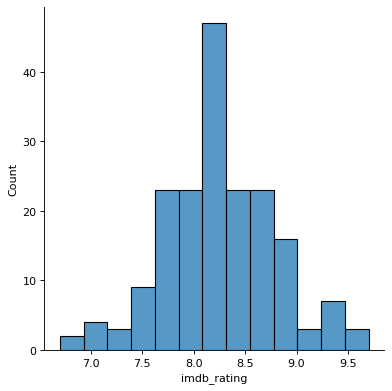

In [6]:
sns.displot(data.imdb_rating)

From the plot above, the distribution of IMDB rating looks like a normal distribution.

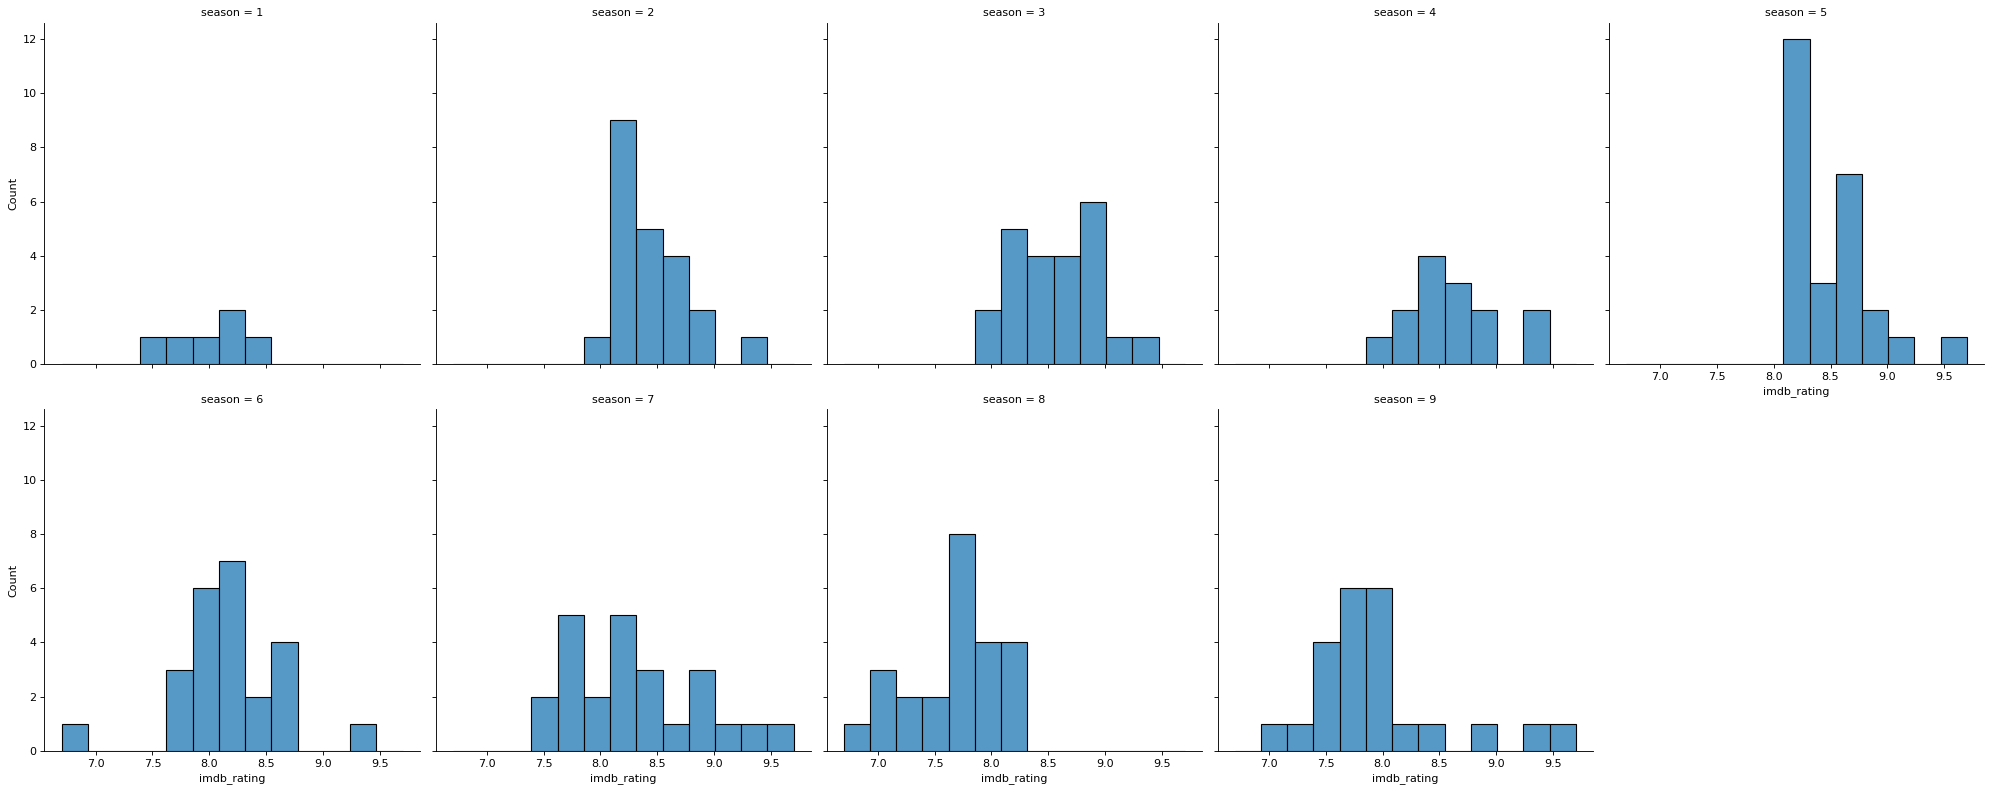

In [67]:
sns.displot(data=data, x='imdb_rating', col='season', col_wrap=5)

Based on the above plots, overall the audience thought that seasons 2, 5, and 7 are the best because the distributions are shifted to right, and season 8 is worse than other seasons due to the high distribution density on the left side.

Text(0.5, 0, 'Episode number')

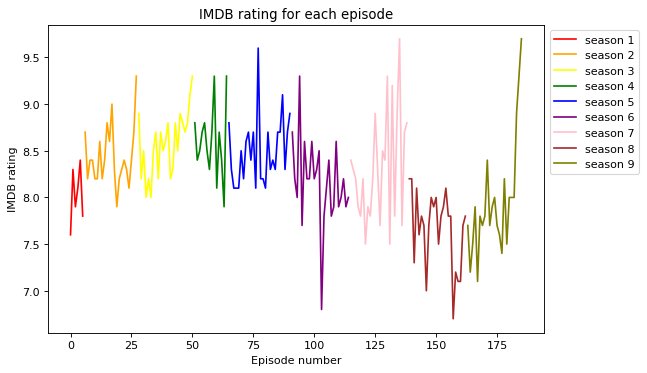

In [8]:
season_color = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'brown', 'olive']

for i in range(1,10):
    plt.plot(data[data.season == i].index, 
             data[data.season == i].imdb_rating, 
             c=season_color[i-1], label=f'season {i}')
    plt.legend(bbox_to_anchor=(1, 1))
    
plt.title('IMDB rating for each episode')
plt.ylabel('IMDB rating')
plt.xlabel('Episode number')

From the plot above, there is one episode from the season 6 with low rating, and on average, the ratings from season 8 are low. As for the high ratings, the episode from season 7 and the finale are rated at a high level. Generally speaking, the conclusion are similar to the distribution plots above, but it is easy to observe the performance of each episode here.

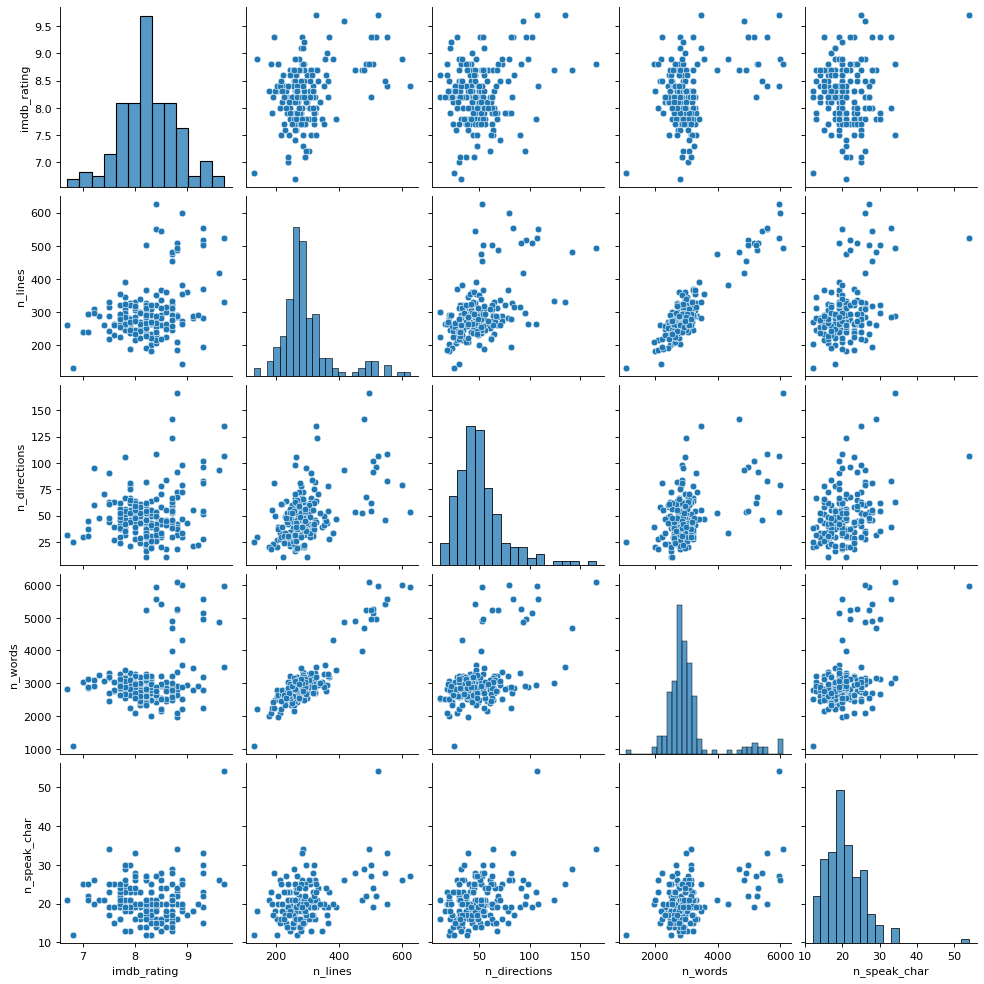

In [9]:
sns.pairplot(data=data.loc[:,['imdb_rating','n_lines','n_directions','n_words','n_speak_char']])

From the pairplot, it seems that the number of lines, the number of lines containing stage directions, the number of words in an episode, and the number of speaking characters have a positive correlation with IMDB ratings. Besides, there are high correlations between the number of lines and the number of words in an episode, which is understandable because as the number of lines increases, the number of words in an episode increases usually. However, it is necessary to keep only one of them in the model to avoid redundancy.

### 2.3 Variable Tidying

There are some columns containing categorical data. Before conducting further analysis, it is essential to perform data preprocessing techniques on them.

In [10]:
data.columns

Index(['season', 'episode', 'episode_name', 'director', 'writer',
       'imdb_rating', 'total_votes', 'air_date', 'n_lines', 'n_directions',
       'n_words', 'n_speak_char', 'main_chars'],
      dtype='object')

`director`, `writer`, `main_chars` are useful categorical data, hence we worked on these variables.

#### `director`

In [11]:
np.sort(data.director.unique())

array(['Alex Hardcastle', 'Amy Heckerling', 'Asaad Kelada', 'B.J. Novak',
       'Brent Forrester', 'Brian Baumgartner', 'Bryan Cranston',
       'Bryan Gordon', 'Charles McDougal', 'Charles McDougall',
       'Charlie Grandy', 'Claire Scanlon', 'Claire Scanlong',
       'Craig Zisk', 'Daniel Chun', 'Danny Leiner', 'David Rogers',
       'Dean Holland', 'Dennie Gordon', 'Ed Helms', 'Eric Appel',
       'Gene Stupnitsky;Lee Eisenberg', 'Greg Daneils', 'Greg Daniels',
       'Harold Ramis', 'J.J. Abrams', 'Jason Reitman', 'Jeffrey Blitz',
       'Jennifer Celotta', 'Jesse Peretz', 'John Krasinski', 'John Scott',
       'Jon Favreau', 'Joss Whedon', 'Julian Farino',
       'Kelly Cantley-Kashima', 'Ken Kwapis', 'Ken Whittingham',
       'Ken Wittingham', 'Lee Eisenberg;Gene Stupnitsky', 'Lee Kirk',
       'Marc Webb', 'Matt Sohn', 'Michael Spiller', 'Miguel Arteta',
       'Mindy Kaling', 'Paul Feig', 'Paul Lieberstein', 'Paul Lieerstein',
       'Rainn Wilson', 'Randall Einhorn', 'Regina

From the results above, there are some misspellings, (the first is the correct one)

>'Charles McDougall'='Charles McDougal'

>'Claire Scanlon'='Claire Scanlong'

>'Greg Daniels'='Greg Daneils'

>'Ken Whittingham'='Ken Wittingham'

>'Paul Lieberstein'='Paul Lieerstein'

>'Gene Stupnitsky;Lee Eisenberg'='Lee Eisenberg;Gene Stupnitsky' (here we used the order of the first letter)

Hence we needed to unify them.

In [12]:
data.loc[data['director'] == 'Charles McDougal', 'director'] = 'Charles McDougall'
data.loc[data['director'] == 'Claire Scanlong', 'director'] = 'Claire Scanlon'
data.loc[data['director'] == 'Greg Daneils', 'director'] = 'Greg Daniels'
data.loc[data['director'] == 'Ken Wittingham', 'director'] = 'Ken Whittingham'
data.loc[data['director'] == 'Paul Lieerstein', 'director'] = 'Paul Lieberstein'
data.loc[data['director'] == 'Lee Eisenberg;Gene Stupnitsky', 'director'] = 'Gene Stupnitsky;Lee Eisenberg'

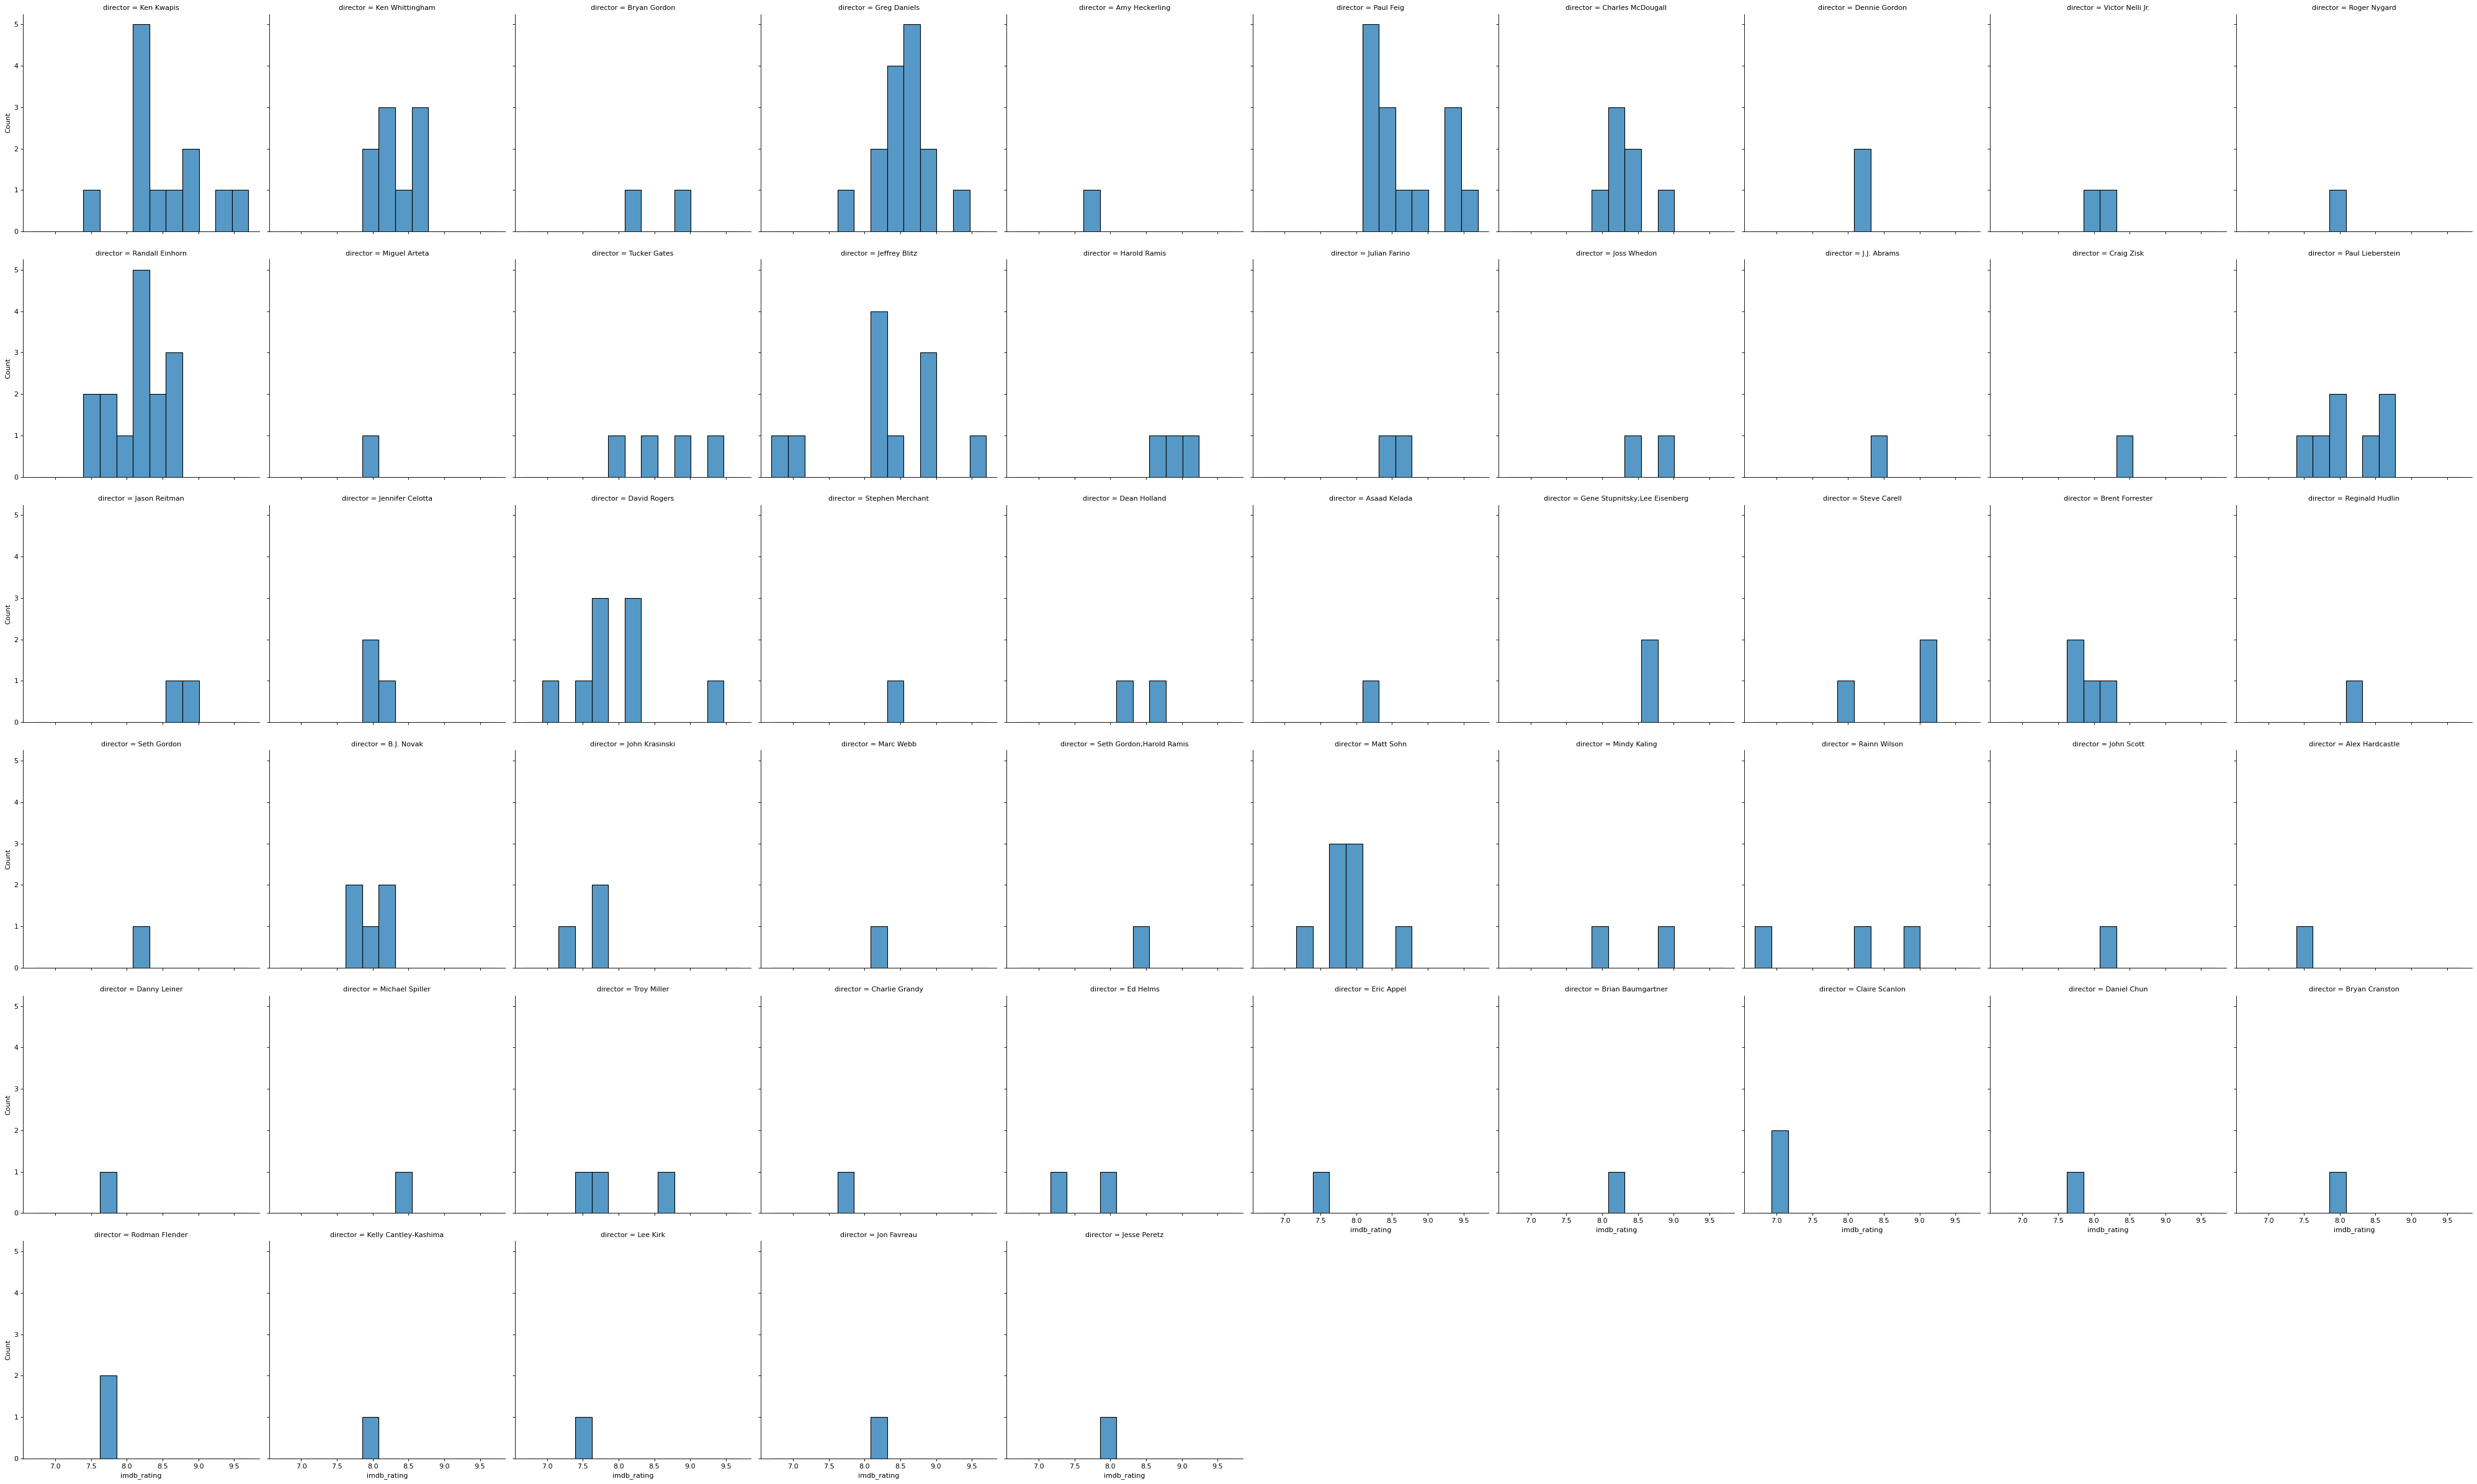

In [69]:
sns.displot(data=data, x='imdb_rating', col='director', col_wrap=10)

From the plot above, we observed that lots of directors only directed the show once. Some directors, such as Ken Kwapis, Greg Daniels, Paul Feig, Tucker Gates, Jeffery Blitz, and David Rogers had experience directing the high ratings episodes.

#### `writer`

In [14]:
np.sort(data.writer.unique())

array(['Aaron Shure', 'Allison Silverman', 'Amelie Gillette',
       'Anthony Q. Farrell', 'B.J. Novak', 'Brent Forrester',
       'Brent Forrester;Justin Spitzer', 'Caroline Williams',
       'Carrie Kemper', 'Charlie Grandy', 'Dan Greaney', 'Dan Sterling',
       'Daniel Chun', 'Daniel Chun;Charlie Grandy',
       'Gene Stupnitsky;Lee Eisenberg', 'Graham Wagner', 'Greg Daniels',
       'Greg Daniels;Mindy Kaling', 'Halsted Sullivan;Warren Lieberstein',
       'Jason Kessler', 'Jennifer Celotta',
       'Jennifer Celotta;Greg Daniels',
       'Jennifer Celotta;Paul Lieberstein', 'Jon Vitti',
       'Jonathan Green;Gabe Miller', 'Jonathan Huges', 'Justin Spitzer',
       'Larry Willmore', 'Lee Eisenberg;Gene Stupnitsky',
       'Lee Eisenberg;Gene Stupnitsky;Michael Schur', 'Lester Lewis',
       'Michael Schur', 'Michael Schur;Lee Eisenberg;Gene Stupnitsky',
       'Mindy Kaling', 'Nicki Schwartz-Wright', 'Owen Ellickson',
       'Paul Lieberstein', 'Paul Lieberstein;Michael Schur', '

There are some identical pairs but with different orders,

>'Gene Stupnitsky;Lee Eisenberg'='Lee Eisenberg;Gene Stupnitsky'

>'Halsted Sullivan;Warren Lieberstein'='Warren Lieberstein;Halsted Sullivan'

>'Lee Eisenberg;Gene Stupnitsky;Michael Schur'='Michael Schur;Lee Eisenberg;Gene Stupnitsky'

Here we adopted the first one in each pair.

In [15]:
data.loc[data['writer'] == 'Lee Eisenberg;Gene Stupnitsky', 'writer'] = 'Gene Stupnitsky;Lee Eisenberg'
data.loc[data['writer'] == 'Warren Lieberstein;Halsted Sullivan', 
         'writer'] = 'Halsted Sullivan;Warren Lieberstein'
data.loc[data['writer'] == 'Michael Schur;Lee Eisenberg;Gene Stupnitsky', 
         'writer'] = 'Lee Eisenberg;Gene Stupnitsky;Michael Schur'

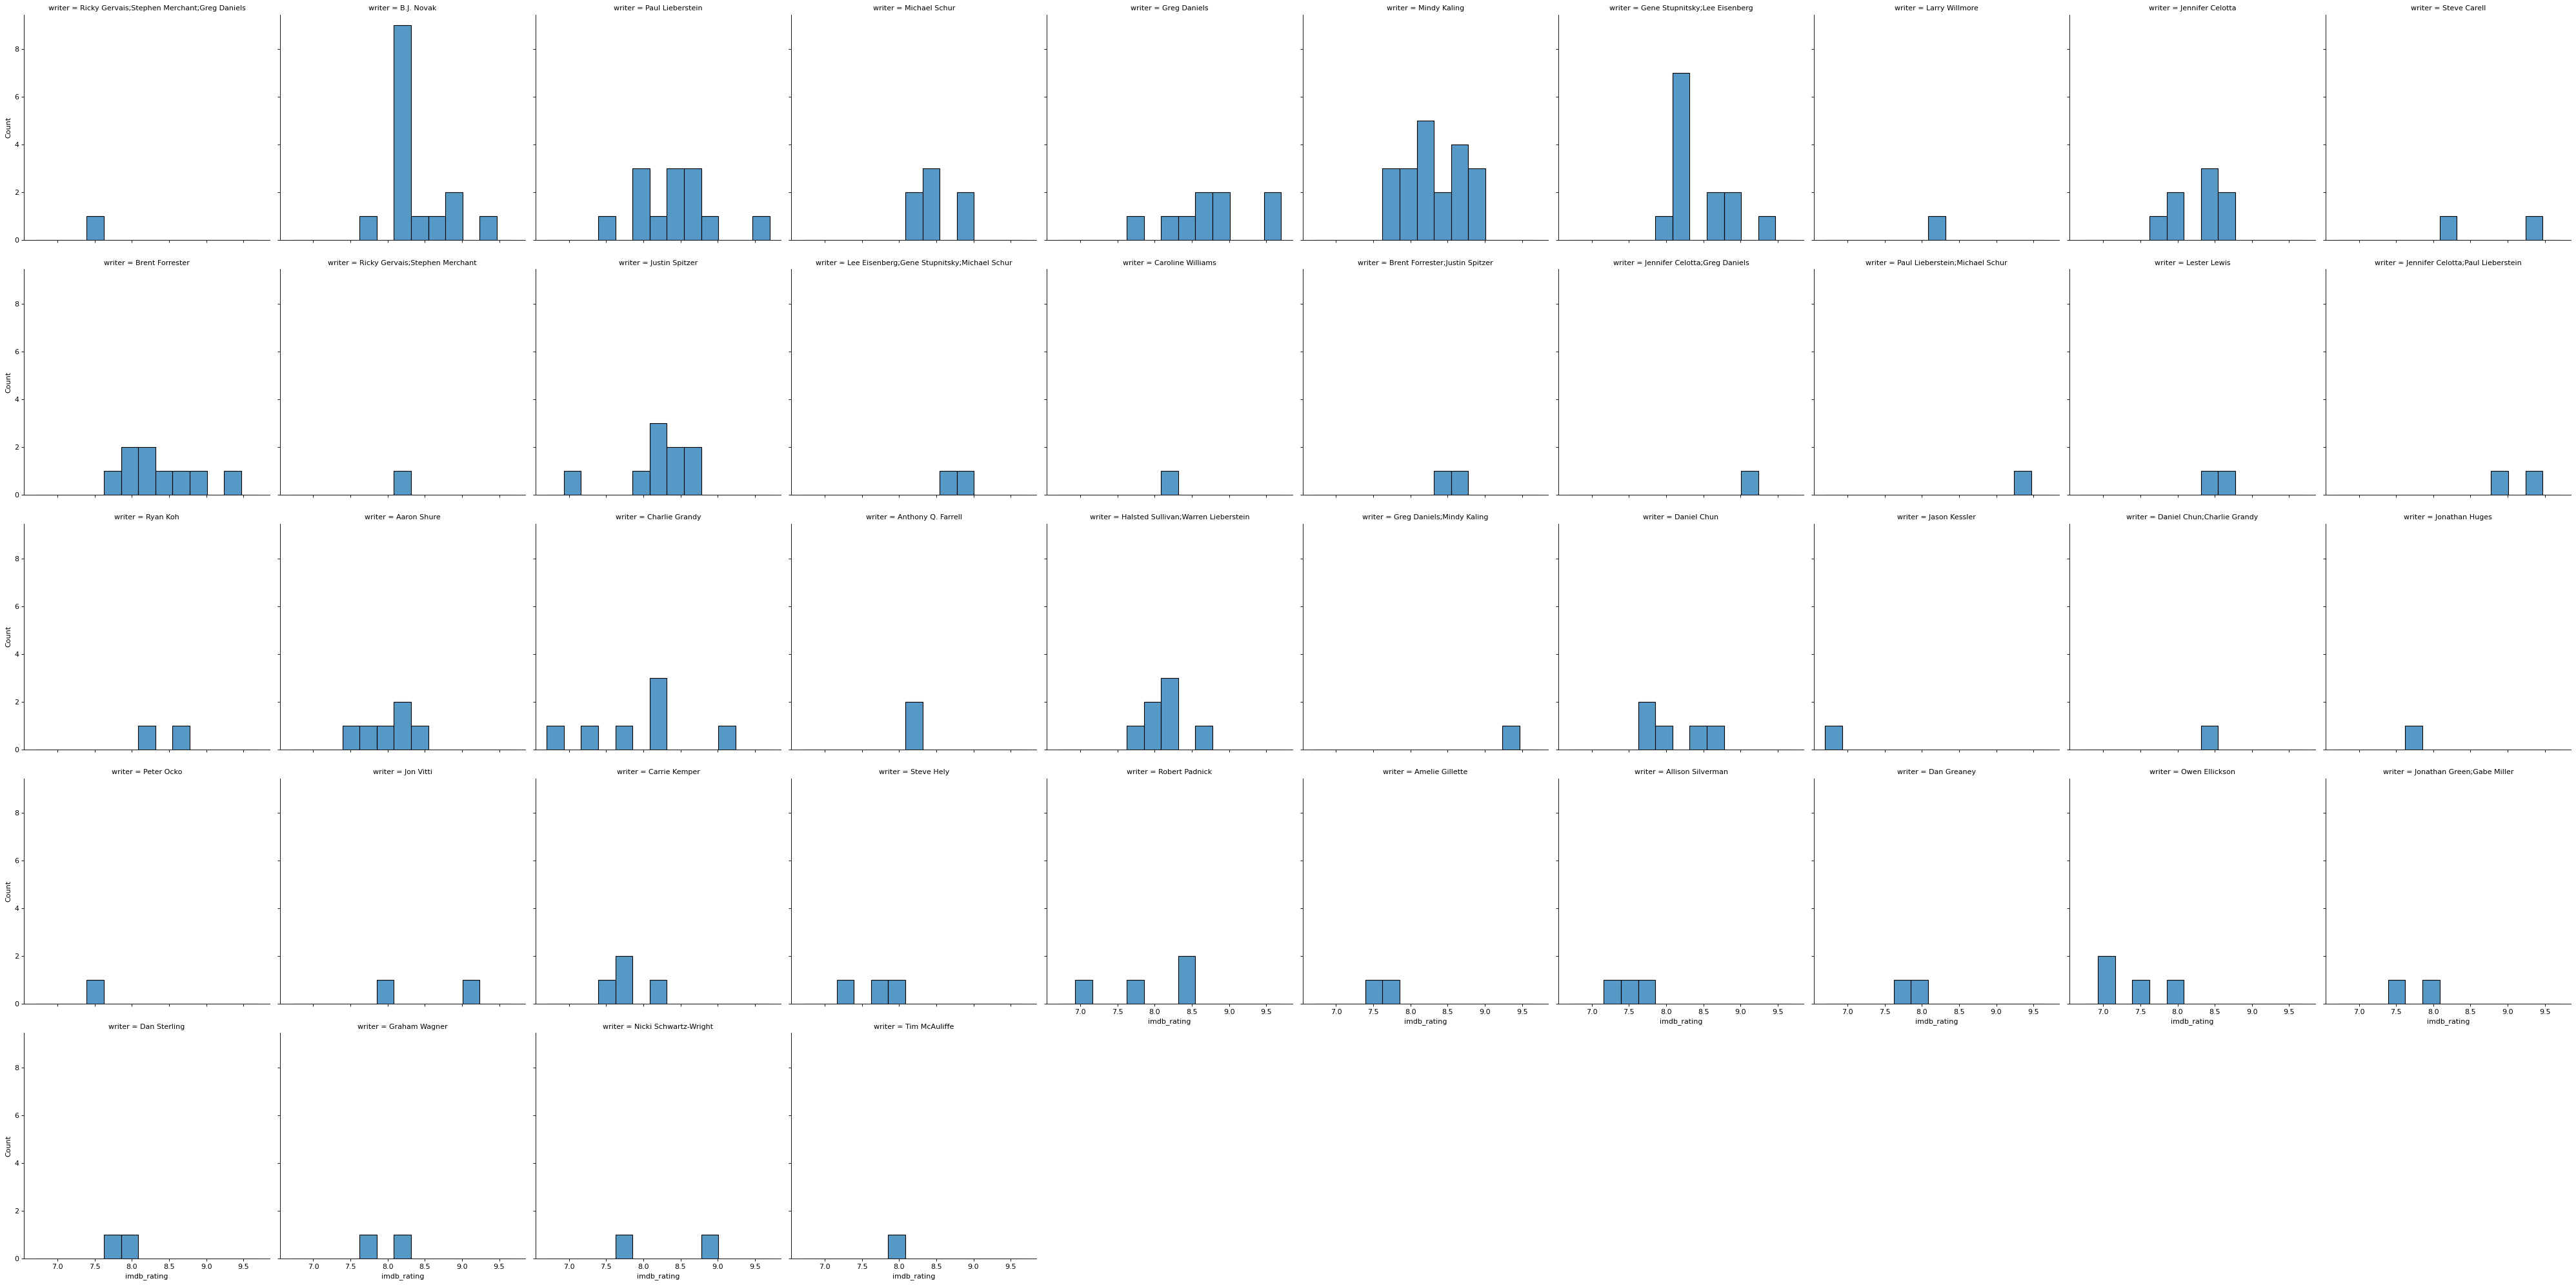

In [68]:
sns.displot(data=data, x='imdb_rating', col='writer', col_wrap=10)

From the plot above, we observed that most episodes are written by the small number of writers. Some writers, such as B.J. Novak, Paul Lieberstein, Greg Daniels, Gene Stupnitsky;Lee Eisenberg, Brent Forrester, Jennifer Celotta;Paul Lieberstein, and Paul Lieberstein;Michael Schur had experience directing the high ratings episodes.

#### `main_chars`

In [17]:
len(np.sort(data.main_chars.unique()))

122

There are too many combinations of the main characters. It is unrealistic to put all of them into the model due to the small data size. We need another way to represent the character data. 

The ultimate goal is to find a combination of features to produce the highest ratings and interpret the results. In this case, some variables are useless, such as `season`, `episode`, `episode_name`(it could be useful but hard to interpret, i.e., what kind of title is eye-attractive), and `air_date`. Some need to be further processed, such as `director`, `writer`, `main_chars`. However, due to the limited dataset, it is impractical to build a model without any selection process to predict what kind of combinations of the directors, the writers, and the main characters produce high-rating episodes. 

To solve the problem, we used two methods, first is to analyse whether the numbers of directors/writers/characters have impact on the ratings. Another is using Lasso regression to select the appropriate covariates, such as what directors/writers could be important factors and should be put in the model, which would be implemented in Section 3.

#### Count the number of directors/writers/characters

In [18]:
data.loc[:,'n_director'] = data.director.str.count(';')+1
data.loc[:,'n_writer'] = data.writer.str.count(';')+1
data.loc[:,'n_main_chars'] = data.main_chars.str.count(';')+1

Because all directors, writers, and main characters are seperated by ";", counting the number of ";" and adding 1 is an easy way to calculate the number of them.

#### Create dummy variables for directors and writers

In [19]:
dir_dummies = pd.get_dummies(data, columns = ["director"])
all_dummies = pd.get_dummies(dir_dummies, columns = ["writer"])

Using these dummy variables for Lasso regression to select the appropriate covariates.

In [20]:
all_dummies.head()

,season,episode,episode_name,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,...,writer_Paul Lieberstein,writer_Paul Lieberstein;Michael Schur,writer_Peter Ocko,writer_Ricky Gervais;Stephen Merchant,writer_Ricky Gervais;Stephen Merchant;Greg Daniels,writer_Robert Padnick,writer_Ryan Koh,writer_Steve Carell,writer_Steve Hely,writer_Tim McAuliffe
0,1,1,Pilot,7.6,3706,2005-03-24,229,27,2757,15,...,0,0,0,0,1,0,0,0,0,0
1,1,2,Diversity Day,8.3,3566,2005-03-29,203,20,2808,12,...,0,0,0,0,0,0,0,0,0,0
2,1,3,Health Care,7.9,2983,2005-04-05,244,21,2769,13,...,1,0,0,0,0,0,0,0,0,0
3,1,4,The Alliance,8.1,2886,2005-04-12,243,24,2939,14,...,0,0,0,0,0,0,0,0,0,0
4,1,5,Basketball,8.4,3179,2005-04-19,230,49,2437,18,...,0,0,0,0,0,0,0,0,0,0


### 2.4 Integrating with dialogue data

#### Calculate the lines every character speaks in an episode

Instead of using all the main charaters with their occurence, we decided to look at the number of lines per character, in this way, we can not only know about the occurence of the characters but also know about the activeness in an episode.

In [21]:
# Get count of number of lines per character per episode
count_lines = lines.groupby(by = ["season", "episode", "speaker"], 
                            as_index = False).count()\
                    .loc[:,["season", "episode", "speaker", "line"]]

In [22]:
count_lines.head()

,season,episode,speaker,line
0,1,1,Angela,1
1,1,1,Dwight,29
2,1,1,Jan,12
3,1,1,Jim,36
4,1,1,Kevin,1


Here we have the number of lines every character speaks in an episode. The next step is to integrate them to original data.

In [23]:
# get all the main characters in main_chars column for further use

char_set = set()

# get all the combination of the main characters in main_chars column
for i in data.main_chars.unique(): 
    temp = i.split(';')
    if char_set == None:
        # use set to store the main characters in the show
        char_set = set(temp) 
    else:
        # combine two sets to eliminate the duplicated items
        char_set = char_set | set(temp) 

In [24]:
for i in char_set: # loop through all characters in main_chars
    # for each character, select the corresponding entries 
    # from count_lines and merge them to all_dummies
    temp = count_lines.loc[count_lines["speaker"] == i]\
        .drop("speaker", axis=1).rename({'line':f'{i}_lines'},
                                        axis='columns')
    all_dummies = pd.merge(all_dummies, temp, on=["season", "episode"],
                           how="outer")

In [25]:
# there must be some N/A values when using outer joins in this case, 
# fill N/A values with 0 to indicate
# there is no line for certain character in an episode
all_dummies.fillna(0, inplace=True) 

In [26]:
all_dummies.head()

,season,episode,episode_name,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,...,Angela_lines,Ryan_lines,Oscar_lines,Pam_lines,Phyllis_lines,Stanley_lines,Erin_lines,Kelly_lines,Creed_lines,Meredith_lines
0,1,1,Pilot,7.6,3706,2005-03-24,229,27,2757,15,...,1.0,8.0,3.0,40.0,2.0,5.0,0.0,0.0,0.0,0.0
1,1,2,Diversity Day,8.3,3566,2005-03-29,203,20,2808,12,...,4.0,4.0,13.0,12.0,0.0,5.0,0.0,2.0,0.0,0.0
2,1,3,Health Care,7.9,2983,2005-04-05,244,21,2769,13,...,5.0,1.0,9.0,32.0,0.0,6.0,0.0,0.0,0.0,3.0
3,1,4,The Alliance,8.1,2886,2005-04-12,243,24,2939,14,...,7.0,4.0,14.0,22.0,5.0,2.0,0.0,0.0,0.0,10.0
4,1,5,Basketball,8.4,3179,2005-04-19,230,49,2437,18,...,3.0,8.0,2.0,14.0,4.0,3.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

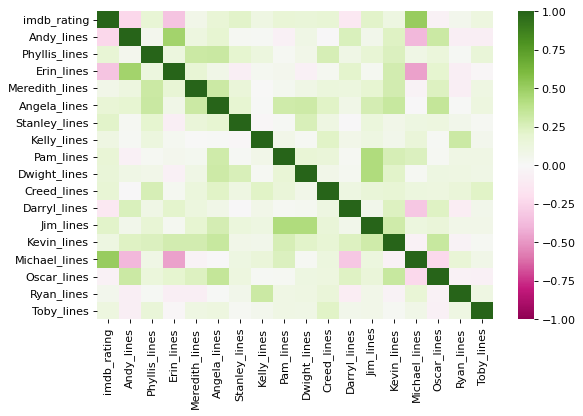

In [27]:
sns.heatmap(all_dummies.loc[:,["imdb_rating", 'Andy_lines', 'Phyllis_lines', 'Erin_lines', 'Meredith_lines',
       'Angela_lines', 'Stanley_lines', 'Kelly_lines', 'Pam_lines',
       'Dwight_lines', 'Creed_lines', 'Darryl_lines', "Jim_lines", "Kevin_lines", 
        "Michael_lines", "Oscar_lines", "Ryan_lines", "Toby_lines"]].corr(),
            vmin = -1, vmax = 1, cmap = 'PiYG')

From the plot above, it is obvious that there are negative correlations between the activeness of Andy/Erin and the ratings. However, there is positive correlations between the activeness of Michael and the ratings.

### 2.5 Feature selection

We used correlation to select the directors and writers would be considered for the model. Because we want to focus on "What directors/writers can produce better episodes? What directors/writers should the team hire?" rather than "What directors/writers can produce worse episodes? What directors/writers the team should not hire?", it is informative to know whether there are positive correlations between the directors/writers and the ratings. We only want to consider the ones with positive correlations.

In [28]:
dir_corr = all_dummies.loc[:, ["imdb_rating", 'director_Alex Hardcastle', 'director_Amy Heckerling',
       'director_Asaad Kelada', 'director_B.J. Novak',
       'director_Brent Forrester', 'director_Brian Baumgartner',
       'director_Bryan Cranston', 'director_Bryan Gordon',
       'director_Charles McDougall', 'director_Charlie Grandy',
       'director_Claire Scanlon', 'director_Craig Zisk',
       'director_Daniel Chun', 'director_Danny Leiner',
       'director_David Rogers', 'director_Dean Holland',
       'director_Dennie Gordon', 'director_Ed Helms',
       'director_Eric Appel', 'director_Gene Stupnitsky;Lee Eisenberg',
       'director_Greg Daniels', 'director_Harold Ramis',
       'director_J.J. Abrams', 'director_Jason Reitman',
       'director_Jeffrey Blitz', 'director_Jennifer Celotta',
       'director_Jesse Peretz', 'director_John Krasinski',
       'director_John Scott', 'director_Jon Favreau',
       'director_Joss Whedon', 'director_Julian Farino',
       'director_Kelly Cantley-Kashima', 'director_Ken Kwapis',
       'director_Ken Whittingham', 'director_Lee Kirk',
       'director_Marc Webb', 'director_Matt Sohn',
       'director_Michael Spiller', 'director_Miguel Arteta',
       'director_Mindy Kaling', 'director_Paul Feig',
       'director_Paul Lieberstein', 'director_Rainn Wilson',
       'director_Randall Einhorn', 'director_Reginald Hudlin',
       'director_Rodman Flender', 'director_Roger Nygard',
       'director_Seth Gordon', 'director_Seth Gordon;Harold Ramis',
       'director_Stephen Merchant', 'director_Steve Carell',
       'director_Troy Miller', 'director_Tucker Gates',
       'director_Victor Nelli Jr.']].corr()

In [29]:
to_drop = set()

for i in range(len(dir_corr.columns)):
    # Drop all directors with negative correlation with IMDB rating
    if (dir_corr.iloc[0, i]) < 0: 
        colname = dir_corr.columns[i]
        to_drop.add(colname)

all_dummies = all_dummies.drop(labels = to_drop, axis = 1)

In [30]:
writer_corr = all_dummies.loc[:, ["imdb_rating", 'writer_Aaron Shure',
       'writer_Allison Silverman', 'writer_Amelie Gillette',
       'writer_Anthony Q. Farrell', 'writer_B.J. Novak',
       'writer_Brent Forrester', 'writer_Brent Forrester;Justin Spitzer',
       'writer_Caroline Williams', 'writer_Carrie Kemper',
       'writer_Charlie Grandy', 'writer_Dan Greaney',
       'writer_Dan Sterling', 'writer_Daniel Chun',
       'writer_Daniel Chun;Charlie Grandy',
       'writer_Gene Stupnitsky;Lee Eisenberg', 'writer_Graham Wagner',
       'writer_Greg Daniels', 'writer_Greg Daniels;Mindy Kaling',
       'writer_Halsted Sullivan;Warren Lieberstein',
       'writer_Jason Kessler', 'writer_Jennifer Celotta',
       'writer_Jennifer Celotta;Greg Daniels',
       'writer_Jennifer Celotta;Paul Lieberstein', 'writer_Jon Vitti',
       'writer_Jonathan Green;Gabe Miller', 'writer_Jonathan Huges',
       'writer_Justin Spitzer', 'writer_Larry Willmore',
       'writer_Lee Eisenberg;Gene Stupnitsky;Michael Schur',
       'writer_Lester Lewis', 'writer_Michael Schur',
       'writer_Mindy Kaling', 'writer_Nicki Schwartz-Wright',
       'writer_Owen Ellickson', 'writer_Paul Lieberstein',
       'writer_Paul Lieberstein;Michael Schur', 'writer_Peter Ocko',
       'writer_Ricky Gervais;Stephen Merchant',
       'writer_Ricky Gervais;Stephen Merchant;Greg Daniels',
       'writer_Robert Padnick', 'writer_Ryan Koh', 'writer_Steve Carell',
       'writer_Steve Hely', 'writer_Tim McAuliffe']].corr()

In [31]:
to_drop = set()

for i in range(len(writer_corr.columns)):
    # Drop all writers with negative correlation with IMDB rating
    if (writer_corr.iloc[0, i]) < 0: 
        colname = writer_corr.columns[i]
        to_drop.add(colname)

all_dummies = all_dummies.drop(labels = to_drop, axis = 1)

### 2.6 Sentiment analysis

We thought that the sentiment, or the mood of each episode is a key factor of ratings. Hence we conducted the sentiment analysis.

In [33]:
# apply the pre-trained sentiment analyzer
sia = SentimentIntensityAnalyzer() 

In [34]:
# combine the sentiment results to the dialogue dataframe
for i, j in enumerate(lines.line):
    pol_score = sia.polarity_scores(j)
    lines.loc[i, 'neg'] = pol_score['neg']
    lines.loc[i, 'neu'] = pol_score['neu']
    lines.loc[i, 'pos'] = pol_score['pos']
    lines.loc[i, 'compound'] = pol_score['compound']

In [35]:
lines.head()

,season,episode,title,speaker,line,neg,neu,pos,compound
0,1,1,Pilot,Michael,All right Jim. Your quarterlies look very good...,0.0,0.803,0.197,0.4927
1,1,1,Pilot,Jim,"Oh, I told you. I couldn't close it. So...",0.0,1.000,0.000,0.0000
2,1,1,Pilot,Michael,So you've come to the master for guidance? Is ...,0.0,1.000,0.000,0.0000
3,1,1,Pilot,Jim,"Actually, you called me in here, but yeah.",0.0,0.714,0.286,0.4215
4,1,1,Pilot,Michael,"All right. Well, let me show you how it's done.",0.0,0.811,0.189,0.2732


Here we want to know the effects of negative and positive sentiment on the rating. So we used the mean value of these two sentiments to represent the overall negative and positive feelings in an episode.

In [70]:
lines_sent = lines.groupby(['season', 'episode'])[['neg', 'pos']]\
    .mean().reset_index()

In [37]:
# merge the sentiment results to the original dataset
all_df = pd.merge(left=all_dummies, right=lines_sent, 
                  on=['season','episode'], how='left')

In [40]:
all_df[['imdb_rating', 'neg', 'pos']].corr()

,imdb_rating,neg,pos
imdb_rating,1.000000,-0.105865,0.025255
neg,-0.105865,1.000000,-0.252272
pos,0.025255,-0.252272,1.000000


The correlation between the rating and the sentiment of each episode is low. It can be related to the overall style of the series (the sentiment of an comedy series should be positive most of time), or the accuracy of the sentiment analysis [1].

## 3. Model Fitting and Tuning

In this project, we emphasized the interpretability of the model. Hence, even though some models such as K-Neighbors regression and Decision Tree regression can perform better than Lasso regression in terms of $R^2$ score and mean squared error, we chose the model that is easy to interpret. For the former models the interpretation of the feature importance is difficult, so it is hard to deliver meaningful results. 

From the last section, we noticed that `n_words` and `n_lines` are extremely highly correlated, so we removed n_words to avoid redundancy. Also, writing a specific number of words in an episode seems more challenging than writing a specific number of lines, so `n_words` was a less useful explanatory variable for our purposes. We did an initial Lasso fit with cross validation using all of the directors and writers who we were considering, and then out of the covariates selected by Lasso we chose the writer and director with the highest magnitude to consider in our model. We made this decision because we are only interested in conveying which writer and which director are the best, not explaining that certain writers and directors contribute to IMDB score by x amount. We then ran LASSO again, with a dataset that only included the most effective writer and the most effective director, to choose our final mdoel.

Hence, in the final dataset, the columns we used are `n_lines`, `n_directions`, `n_speak_char`, `n_director`, `n_writer`, `n_main_chars`, the covariates related to activeness (`_lines` columns), sentiment data (`neg`, `pos`), the most effective writer Jennifer Celotta;Paul Lieberstein and the director Tucker Gates, which corresponds to the findings before because they have experience tproducing highly rated episodes.

We also considered average words per line, however the models did not have improved performance in terms of r squared and mean squared error, and words per line is harder to interpret, so we chose to stick with the number of lines model. We attempted to add interaction terms between main characters and add the dummy variables of `main_chars` from the original dataset as well, but they didn't improve the model. As a result, we didn't include them in our final model.

Besides the K-Neighbors regression and Decision Tree regression we mentioned before, we also tried linear regression, but it tended to overfit the data due to the small dataset and number of many variables. So we decided to use Lasso regression to strike a balance between interpretability and accuracy.

### 3.1 Preparing the final dataset

In [41]:
X_df = all_df[['n_lines', 'n_directions', 'n_speak_char','n_director', 
               'n_writer', 'n_main_chars', 'Andy_lines', 'Erin_lines',
               'Kevin_lines', 'Pam_lines','Phyllis_lines', 'Toby_lines', 
               'Kelly_lines', 'Jim_lines','Darryl_lines', 'Creed_lines', 'Ryan_lines',
               'Oscar_lines', 'Dwight_lines', 'Angela_lines', 'Meredith_lines',
               'Stanley_lines', 'Michael_lines', 'neg','pos', 
               'director_Tucker Gates', 'writer_Jennifer Celotta;Paul Lieberstein']]

In [42]:
# intialise the response variable
y = all_df['imdb_rating']

In [43]:
# separate data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_df.values, y.values, 
                                                    test_size=0.2,
                                                    random_state=50)

### 3.2 Fit the model

Before fitting the data using Lasso regression, we needed to standardised the data, and use the function `LassoCV` provided by sklearn to choose the appropriate parameters $\alpha$. Here we used the default settings, 5-fold cross validation to search for optimised $\alpha$.

In [44]:
# Create pipeline for lasso model
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('lasso', LassoCV(random_state=50, 
                                   max_iter=50000))])

In [45]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', LassoCV(max_iter=50000, random_state=50))])

### 3.3 Model Summary

In [46]:
# alpha chosen by cross-validation
pipe['lasso'].alpha_

0.052581394223206825

In [47]:
pipe['lasso'].coef_

array([ 0.06883075,  0.00527459,  0.        ,  0.        ,  0.        ,
        0.        , -0.00083673, -0.02571909,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.01854141,  0.16873147, -0.        , -0.        ,
        0.03786808,  0.01168099])

In [48]:
pipe['lasso'].intercept_

8.279054054054056

To help interpreting the model results, we put them in a dataframe with corresponding variable names.

In [49]:
lcv_coef = pd.DataFrame(data=pipe['lasso'].coef_, index=X_df.columns, 
                        columns=['coef'])

In [50]:
lcv_intercept = pd.DataFrame(data=pipe['lasso'].intercept_, 
                             index=['Intercept'], columns=['coef'])

In [51]:
lcv_c = pd.concat([lcv_coef, lcv_intercept])

In [52]:
lcv_c.loc[lcv_c.coef != 0, :]

,coef
n_lines,0.068831
n_directions,0.005275
Andy_lines,-0.000837
Erin_lines,-0.025719
Stanley_lines,0.018541
Michael_lines,0.168731
director_Tucker Gates,0.037868
writer_Jennifer Celotta;Paul Lieberstein,0.011681
Intercept,8.279054


The Lasso method did not choose any of the sentiment analysis data for explaining the imdb rating, which corresponding to the findings above because of the weak correlation between IMDB rating and the sentiment results. Besides, `Andy_lines`, `Erin_lines`, `Michael_lines` are selected by the model, align with the observations as well. Interestingly, `Stanley_lines` is in the model, although it doesn't have high correlation with IMDB rating. 

In [53]:
# R-squared for pipe
pipe.score(X_train, y_train)

0.3150325072728365

In [54]:
y_pred = pipe.predict(X_train)

In [55]:
# Mean squared error for pipe
mean_squared_error(y_train, y_pred)

0.18487211336874257

Looking at the R-squared score, the model can explain the around 31% of variation of the training data. And the mean squared error is around 0.185. To know the ability of prediciton on the unseen dataset, we did the cross validation.

In [56]:
# use the alpha chosen by cross-validation
pipe_cv = Pipeline([('scaler', StandardScaler()), 
                    ('lasso', Lasso(random_state=50, max_iter=50000,
                                    alpha=pipe['lasso'].alpha_))])

In [57]:
cross_validate(pipe_cv, X_train, y_train, 
               scoring=['r2', 'neg_mean_squared_error'])

{'fit_time': array([0.00100803, 0.00050402, 0.00043201, 0.00042796, 0.00043297]),
 'score_time': array([0.0002377 , 0.00019193, 0.00018525, 0.00018096, 0.00017977]),
 'test_r2': array([0.21521269, 0.22669955, 0.24348834, 0.24644048, 0.10051398]),
 'test_neg_mean_squared_error': array([-0.17931518, -0.2245063 , -0.2027115 , -0.19993968, -0.22178053])}

From the results above, the R-squared scores are unstable. One possible reason is that the limited dataset causes unequivalent training dataset for fitting when spliting and further causes the unstable results of R_squared. But looking at mean square error, the performances don't differ a lot.

### 3.4 Model assumption check

Using the linear model, we needed to check the residuals are normally distributed, have constant variance and mean 0.

In [58]:
# Calculate the residuals
res = y_train - y_pred

Text(0.5, 1.0, 'Residual plot (Residuals vs. Index)')

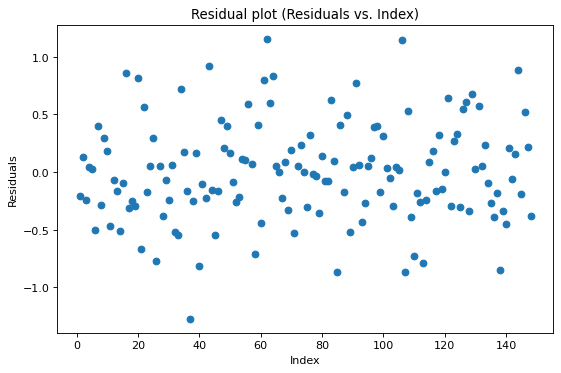

In [59]:
plt.scatter(range(1, len(y_train)+1), res)
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Residual plot (Residuals vs. Index)')

The residuals are around 0, indicating the mean of residuals are close to 0.

Text(0.5, 1.0, 'Residual plot (Residuals vs. Fitted values)')

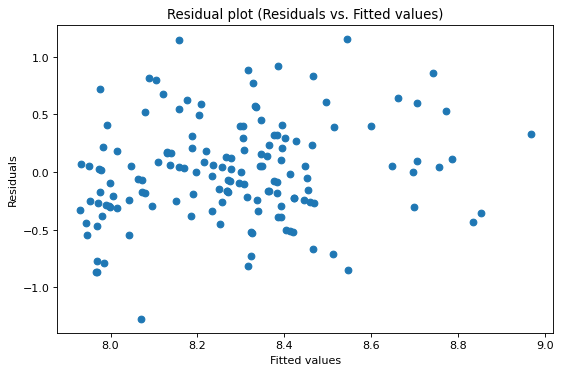

In [60]:
plt.scatter(y_pred, res)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual plot (Residuals vs. Fitted values)')

From the plot above, there is no pattern between the residuals and fitted values, and the points don't spread or shrink, so the constant variance holds.

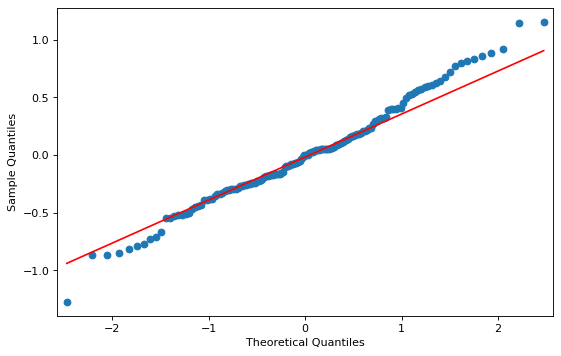

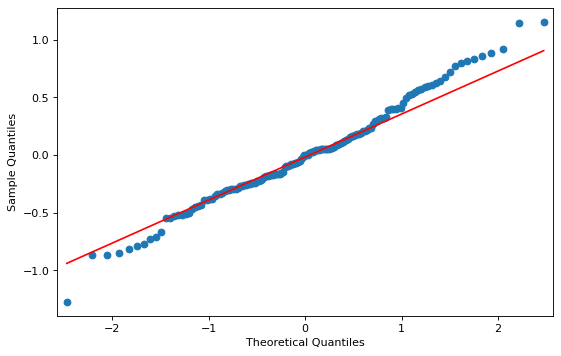

In [61]:
qqplot(res, line='q')

From Q-Q plot, the residuals are close to normal distribution. In conclusion, the residuals meet all the assumptions of linear regression, and it is reasonable to use linear regression to fit the data.

### 3.5 Prediction on the testing data

In [63]:
# R-squared for pipe
pipe.score(X_test, y_test)

0.2653948039816859

In [64]:
y_pred_t = pipe.predict(X_test)

In [65]:
# Mean squared error for pipe
mean_squared_error(y_test, y_pred_t)

0.24069512215522496

Apply our model to the testing data, it still can explain 27% of variation in the data and the mean square error is around 0.241, which are close to the results from training data, indicating there is no serious overfitting problem. Besides, the results are better than the testing results from cross validation. 

Text(0.5, 1.0, 'Predicted ratings vs. Actual ratings')

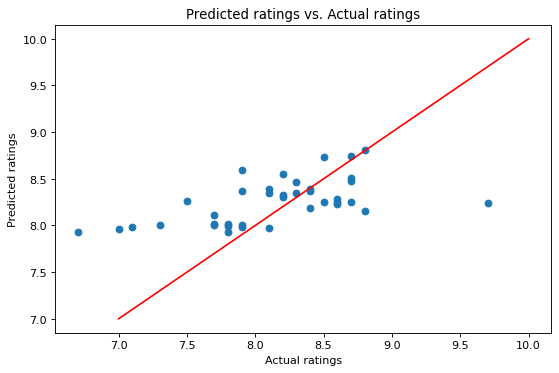

In [66]:
plt.scatter(y_test, y_pred_t)
plt.plot([7,10],[7,10], c='r')
plt.xlabel('Actual ratings')
plt.ylabel('Predicted ratings')
plt.title('Predicted ratings vs. Actual ratings')

From the plot above, although our model tends to underestimate the ratings when the actual ratings are high. However, the direction is correct, that is, the model still can assign the high ratings to the good episodes but a little underestimate the scores.

## 4. Discussion and Conclusions


In our final model, we used the variables `n_lines`, `n_directions`, `Andy_lines`, `Erin_lines`, `Stanley_lines`, `Michael_lines`, `director_Tucker Gates`, `writer_Jennifer Celotta;Paul Lieberstein` to predict the IMDB ratings. The testing R-squared score is around 0.27 and the mean squared error is around 0.24. In normal setting, the R-squared is not impressive, but considering the small dataset and the complicated interaction, including the social factors and psychological factors, in the real world, the results are acceptable. The most important, although it would provide the conservative prediction, it still can provide the true tendency of the ratings. In other words, it can help predict what kind of episodes can receive higher ratings than others. Based on the parameter estimations, when the characters have more dialogue and with more stage directions, Stanley and Michael are more active, the ratings would be higher. Besides, we should hire Jennifer Celotta and Paul Lieberstein as the writers, and Tucker Gates as the director, and try to lower the activeness of Andy and Erin. In this case, the reunion episode would be very popular.

## 5. References

[1] The accuracy of the sentiment analysis based on vader,
https://towardsdatascience.com/the-best-python-sentiment-analysis-package-1-huge-common-mistake-d6da9ad6cdeb

The technique of sentiment analysis,
https://realpython.com/python-nltk-sentiment-analysis/#installing-and-importing

The dataset(the lines in every episode),
https://www.kaggle.com/code/nilimajauhari/the-office-sentiment-analysis/data

Official Documentation of `LassoCV`,
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html